In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from math import log, sqrt
import re
import pandas as pd
import numpy as np

from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator

from sklearn.pipeline import Pipeline
from gensim.models import KeyedVectors

# -- classifiers -- #
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [2]:
"""# Loading the Data"""
tweets = pd.read_csv('DepressionTweets.csv')
tweets = tweets.iloc[np.random.permutation(len(tweets))]
# split train/test
trainData, testData= train_test_split(tweets, train_size=0.7)
print('The training set contains {} samples and the test set contains {} samples'.format(trainData.shape[0], testData.shape[0]))



The training set contains 560 samples and the test set contains 240 samples


In [3]:
"""# Stop words removing"""

import codecs

def get_stop_words():
    path = "stop-words-list.txt"
    stop_wordsx = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_wordsx = myfile.readlines()
    stop_wordsx = [word.strip() for word in stop_wordsx]
    return stop_wordsx

stop_word=get_stop_words()
stop_word.append('_')
stop_word.append('?')
stop_word.append('#')

depressive_words = ' '.join(list(tweets[tweets['Sentiment'] == 1]['text']))
depressive_words = word_tokenize(depressive_words)
depressive_words = [w for w in depressive_words if len(w) > 2]
depressive_words = [word for word in depressive_words if word not in stop_word]
depressive_words = ' '.join(list(depressive_words))

(-0.5, 294.5, 364.5, -0.5)

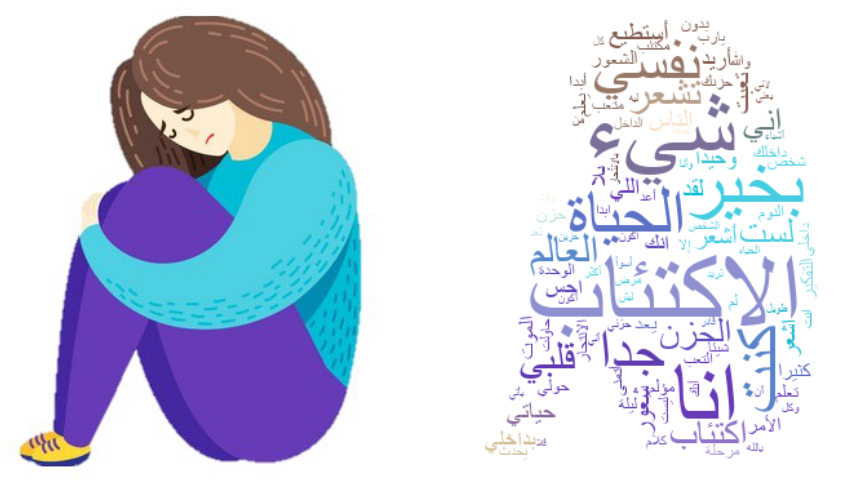

In [4]:
"""# Wordcloud Analysis"""

char_mask = np.array(Image.open("image.jpg"))
image_colors = ImageColorGenerator(char_mask)

reshaped_texts = arabic_reshaper.reshape(depressive_words)
arabic_texts = get_display(reshaped_texts)

depressive_wc = WordCloud(background_color="white",font_path='arial',max_words=100,width = 512,height = 512, collocations=False,mask=char_mask).generate(arabic_texts)

fig =plt.figure(figsize = (15,15))

ax2 = fig.add_subplot(1,2,1)
ax2.imshow(char_mask, cmap=plt.cm.gray, interpolation='bilinear')
ax2.axis('off')

ax1 = fig.add_subplot(1,2,2)
ax1.imshow(depressive_wc.recolor(color_func=image_colors), interpolation="bilinear")
ax1.axis('off')

In [5]:
"""# tweet Analysis"""


class ArSentiment(object):
    def __init__(self, embeddings_file=None, trainData=None,  testData=None):
        
        self.trainData = trainData
        self.testData = testData

        self.embeddings, self.dimension = self.load_vectors(embeddings_file)

        # read dataset
        train_txt, test_txt = trainData['text'], testData['text']
        self.y_train = trainData['Sentiment']
        self.y_test = testData['Sentiment']

    
        # -- dataset preprocessing -- #
        train_tokens = self.tokenize_data(train_txt, 'training')
        test_tokens = self.tokenize_data(test_txt, 'testing')

        # -- vectorize training/testing data -- #
        train_vectors = self.average_feature_vectors(train_tokens, 'training')
        test_vectors = self.average_feature_vectors(test_tokens, 'testing')

        # vectorized features
        self.X_train = self.remove_nan(train_vectors)
        self.X_test = self.remove_nan(test_vectors)

        
        # classifiers to use
        classifiers = [
            RandomForestClassifier(n_estimators=100),
            LinearSVC(C=1e1),
            NuSVC(),
            LogisticRegressionCV(solver='liblinear'),
            GaussianNB(),
            BernoulliNB(),
            SGDClassifier(), 
        ]

        self.accuracies = {}

        # RUN classifiers
        for c in classifiers:
            self.classifyx(c)
            


    @staticmethod
    def load_vectors(model_name, binary=True):

        if binary:
            w2v_model = KeyedVectors.load_word2vec_format(model_name, binary=True)
        else:
            w2v_model = KeyedVectors.load(model_name)

        w2v_model.init_sims(replace=True)  # to save memory
        vocab, vector_dim = w2v_model.syn0.shape
        return w2v_model, vector_dim

    @staticmethod
    def tokenize(text):
        
        try:
            try:
                txt = unicode(text, 'utf-8')  # py2
            except NameError:
                txt = text  # py3  
            words = word_tokenize(txt)
            words = [w for w in words if len(w) > 2]
            sw = stop_word
            words = [word for word in words if word not in sw]
            stemmer = ISRIStemmer()
            words = [stemmer.stem(word) for word in words] 
            length = len(words)
        except TypeError:
            print(words)
            words, length = ['NA'], 0
        return words, length

    def tokenize_data(self, examples_txt, type_='NaN'):
        tokens = []
        total_tokens = []
        for txt in examples_txt:
            words, num = self.tokenize(txt)
            tokens.append(words)
            total_tokens.append(num)
        return tokens

    def feature(self, words):
        feature_vec = np.zeros((self.dimension,), dtype="float32")
        retrieved_words = 0
        for token in words:
            try:
                feature_vec = np.add(feature_vec, self.embeddings[token])
                retrieved_words += 1
            except KeyError:
                pass  # if a word is not in the embeddings' vocabulary discard it

        np.seterr(divide='ignore', invalid='ignore')
        feature_vec = np.divide(feature_vec, retrieved_words)

        return feature_vec

    def average_feature_vectors(self, examples, type_='NaN'):
       
        feature_vectors = np.zeros((len(examples), self.dimension), dtype="float32")
        for i, example in enumerate(examples):
            feature_vectors[i] = self.feature(example)
        return feature_vectors

    def classifyx(self, classifier=None):

        classifier_name = classifier.__class__.__name__ 
        classifier.fit(self.X_train, self.y_train)
        pscore = classifier.score(self.X_test, self.y_test)

        # F1 score
        y_pred = classifier.predict(self.X_test)
        f1_score = metrics.f1_score(self.y_test, y_pred)

        # accuracy 
        acc = metrics.accuracy_score(self.y_test, y_pred, normalize=True, sample_weight=None)

        # precision and recall
        recall = metrics.recall_score(self.y_test, y_pred)
        precision = metrics.precision_score(self.y_test, y_pred)

        results = [acc, precision, recall, f1_score]
        self.accuracies[classifier_name] = results

             
    @staticmethod
    def remove_nan(x):
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        x_clean = imp.fit_transform(x)
        return x_clean

    
    
def process_message(message):
    
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    words = [word for word in words if word not in stop_word]
    stemmer = ISRIStemmer()
    words = [stemmer.stem(word) for word in words]  
    
    return words

class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['text'], trainData['Sentiment']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

def metricsz(labels, predictions, model):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    
    precision=precision*100
    recall=recall*100
    Fscore=Fscore*100
    accuracy=accuracy*100
    
    print('{0:25}{1:10.3f}{2:12.3f}{3:10.3f}{4:10.3f}'.format(model, accuracy, precision, recall, Fscore))

In [8]:
"""# running"""

# vectors file
embeddings_path = "arabic-news.bin"

# run
W2V=ArSentiment(embeddings_path, trainData, testData)

sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['text'])

sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['text'])

print('\n\n--------------------------------------------------------------------------------------------------------------------') 
print('\n******************************************* Detect Depression on Twitter *******************************************') 
print('\n--------------------------------------------------------------------------------------------------------------------\n') 



    
print('\n\n{0:28}{1:20}{2:12}'.format('Dataset','Depressive_tweets ', 'Undepressive_tweets'))
print('---------------------------------------------------------------------')   
print('  {0:21}{1:17}{2:17}'.format('Train Data', len(trainData[trainData['Sentiment'] == 1]), len(trainData[trainData['Sentiment'] == 0])))
print('  {0:21}{1:17}{2:17}'.format('Test  Data', len(testData[testData['Sentiment'] == 1]),len(testData[testData['Sentiment'] == 0])))
print('  {0:21}{1:17}{2:17}'.format('Total Data', len(tweets[tweets['Sentiment'] == 1]),len(tweets[tweets['Sentiment'] == 0])))
print('\n\n')


print('\n\n{0:28}{1:10}{2:12}{3:10}{4:10}'.format('Algorithm','Accuracy', 'Precision', 'Recall','F-score'))
print('---------------------------------------------------------------------') 

for k, v in W2V.accuracies.items():
    print('{0:25}{1:10.3f}{2:12.3f}{3:10.3f}{4:10.3f}'.format(k, v[0] * 100,  v[2] * 100, v[3] * 100, v[1] * 100))

metricsz(testData['Sentiment'], preds_tf_idf,'Bayes Therom (TF-IDF)')

metricsz(testData['Sentiment'], preds_bow,'Bayes Therom (BOW)')


C:\Users\amal\Anaconda3\envs\mne\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).




--------------------------------------------------------------------------------------------------------------------

******************************************* Detect Depression on Twitter *******************************************

--------------------------------------------------------------------------------------------------------------------



Dataset                     Depressive_tweets   Undepressive_tweets
---------------------------------------------------------------------
  Train Data                         287              273
  Test  Data                         113              127
  Total Data                         400              400





Algorithm                   Accuracy  Precision   Recall    F-score   
---------------------------------------------------------------------
RandomForestClassifier       76.250      70.796    73.733    76.923
LinearSVC                    74.167      72.566    72.566    72.566
NuSVC                        78.333      75.221 